### Importing ll the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

#nltk.download("stopwords")
#nltk.download("punkt")
#nltk.download("wordnet")

### Importing the data from csv file

In [2]:
data = pd.read_csv("airline_tweets.csv")

In [3]:
data.head()

,airline,text,tweet_location
0,Virgin America,@VirginAmerica What @dhepburn said.,NaN
1,Virgin America,@VirginAmerica plus you've added commercials t...,NaN
2,Virgin America,@VirginAmerica I didn't today... Must mean I n...,Lets Play
3,Virgin America,@VirginAmerica it's really aggressive to blast...,NaN
4,Virgin America,@VirginAmerica and it's a really big bad thing...,NaN


In [1]:
### Creating a function to clean the text and extract only useful information

In [4]:
def clean_text(text):
    if isinstance(text, str):  
        text = text.lower()  
        text = re.sub(r"http\S+|www\S+", "", text)  
        text = re.sub(r"@\w+", "", text)  
        text = re.sub(r"#\w+", "", text)  
        text = re.sub(r"[^a-zA-Z\s]", "", text)  
        text = re.sub(r"\s+", " ", text).strip()  
        
        words = word_tokenize(text)

        stop_words = set(stopwords.words("english"))
        words = [word for word in words if word not in stop_words]

        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        return " ".join(words)
    return ""


In [5]:
data["cleaned_text"] = None
data["cleaned_text"] = data["text"].apply(clean_text)

In [6]:
data.head()

,airline,text,tweet_location,cleaned_text
0,Virgin America,@VirginAmerica What @dhepburn said.,NaN,said
1,Virgin America,@VirginAmerica plus you've added commercials t...,NaN,plus youve added commercial experience tacky
2,Virgin America,@VirginAmerica I didn't today... Must mean I n...,Lets Play,didnt today must mean need take another trip
3,Virgin America,@VirginAmerica it's really aggressive to blast...,NaN,really aggressive blast obnoxious entertainmen...
4,Virgin America,@VirginAmerica and it's a really big bad thing...,NaN,really big bad thing


### Creating TF-IDF vectors for the cleaned text

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_vectors = tfidf_vectorizer.fit_transform(data['cleaned_text'])

print("TF-IDF shape:", tfidf_vectors.shape)

TF-IDF shape: (14640, 5000)


### Importing data for training the model and building an SVM

In [8]:
train_data = pd.read_csv("tweet_sentiment.csv")
train_data["cleaned_text"] = train_data["cleaned_text"].fillna("")


In [9]:
tfidf_vectors_train = tfidf_vectorizer.fit_transform(train_data['cleaned_text'])
print("TF-IDF shape:", tfidf_vectors_train.shape)

TF-IDF shape: (4869, 5000)


In [10]:
X_tfidf_train = tfidf_vectors_train.toarray()
y = train_data['label']

In [11]:
svm_model = SVC(C=10, kernel='rbf', gamma='scale')
svm_model.fit(X_tfidf_train, y)


SVC(C=10)

### Using the model to predict the sentiment of airlines tweet

In [12]:
airlines_tweets = tfidf_vectors.toarray()
airlines_sentiment = svm_model.predict(airlines_tweets)

In [13]:
data["sentiment"] = airlines_sentiment

### Ploting a clustered column chart 

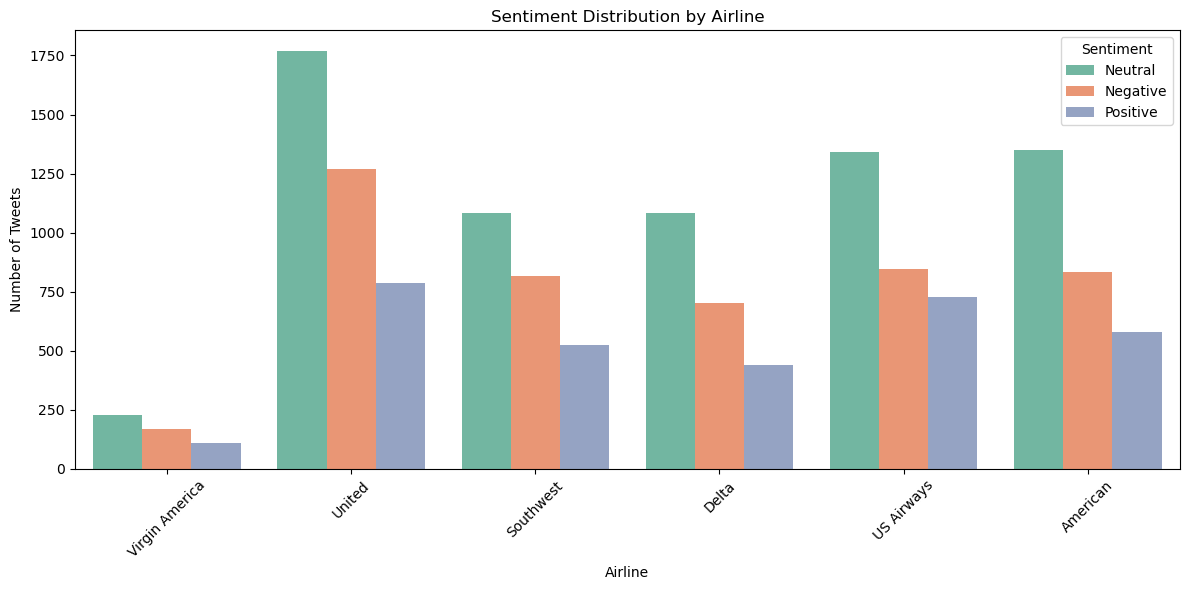

In [14]:
sentiment_map = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
data['sentiment_label'] = data['sentiment'].map(sentiment_map)

# Set plot style
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='airline', hue='sentiment_label', palette='Set2')

plt.title('Sentiment Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Saving the data into an excel file 

In [15]:
data.to_excel("airlines_sentiment.xlsx", index=False)